In [20]:
from io import StringIO

import matplotlib.pyplot as plt
from scipy.io import arff
import seaborn as sns
from loguru import logger
import yaml

from datetime import datetime
import polars as pl
import pandas as pd
import numpy as np
import joblib
import os

# MODEL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import (
    LabelEncoder, 
    StandardScaler,
    label_binarize
)
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_recall_fscore_support,
    balanced_accuracy_score,
    roc_auc_score,
    roc_curve
)

# IMPORTANDO FUNCIONALES DE SISTEMA
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

# PERSONAL FUNCTIONS
from utils import *
from models.main import *
from functions.windows import create_feature_windows # creación de ventanas e ingenieria de características

In [13]:
df_acce = pl.read_csv('./data/Watch_accelerometer.csv')
df_gyro = pl.read_csv('./data/Watch_gyroscope.csv')

In [2]:
features_accel = pd.read_csv(r"F:\UPC\Tesis\HARbit-Model\src\data\preprocess\accel_50%-overlaping_5s-windows.csv")
features_gyro = pd.read_csv(r"F:\UPC\Tesis\HARbit-Model\src\data\preprocess\gyro_50%-overlaping_5s-windows.csv")

In [3]:
featured_combined = pd.merge(
    features_accel,
    features_gyro,
    on=['Subject-id', 'Activity Label', 'window_start', 'window_end', 'sample_count'], 
    how="inner"
)

In [4]:
with open(r"F:\UPC\Tesis\HARbit-Model\src\config\activities.yaml", 'r') as file:
    config_activities = yaml.safe_load(file)['config']

In [5]:
_clusters = config_activities['clusters']
_decoders = config_activities['labels']

In [6]:
for label in _decoders.keys():
    featured_combined.loc[featured_combined['Activity Label'] == label, 'Activity Label'] = _decoders[label]

In [7]:
for group in _clusters.keys():
    for activity in _clusters[group]:
        featured_combined.loc[featured_combined['Activity Label'] == activity, 'Activity Label'] = group

In [8]:
X_triple, y_triple, label_encoder = get_features_split(featured_combined)

Características detectadas: 136
Muestras totales: 60710
Número de clases: 8
Clases: ['Eat' 'Others' 'Sit' 'Stand' 'Type' 'Walk' 'Workouts' 'Write']


In [9]:
X_train, X_test, X_val = X_triple
y_train, y_test, y_val = y_triple
num_classes = len(label_encoder.classes_)

In [10]:
input_shape = (X_train.shape[1], X_train.shape[2])

In [11]:
model = create_cnn_lstm_model(input_shape = input_shape, num_classes = num_classes)

c:\Users\HP\miniconda3\envs\forecasting\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
history = model.fit(
    X_train, y_train,
    validation_data =   (X_val, y_val),
    epochs          =   100,
    batch_size      =   32,
    callbacks       =   callbacks,
    verbose         =   1
)

Epoch 1/100
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.6019 - loss: 1.1491 - val_accuracy: 0.8127 - val_loss: 0.5495 - learning_rate: 0.0010
Epoch 2/100
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.6019 - loss: 1.1491 - val_accuracy: 0.8127 - val_loss: 0.5495 - learning_rate: 0.0010
Epoch 2/100
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7716 - loss: 0.7070 - val_accuracy: 0.8536 - val_loss: 0.4340 - learning_rate: 0.0010
Epoch 3/100
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7716 - loss: 0.7070 - val_accuracy: 0.8536 - val_loss: 0.4340 - learning_rate: 0.0010
Epoch 3/100
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8081 - loss: 0.6153 - val_accuracy: 0.8686 - val_loss: 0.4050 - learning_rate: 0.0010
Epoch 4/100
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8081 - loss: 0.6153 - val_accuracy: 0.8686 - val_loss: 0.4050 - learning_rate: 0.0010
Epoch 4/100
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accura

Evaluando modelo...
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

Pérdida en test: 0.2219
Precisión en test: 0.9283

REPORTE DE CLASIFICACIÓN
              precision    recall  f1-score   support

         Eat     0.9151    0.9364    0.9257      3397
      Others     0.9328    0.9740    0.9530      2038
         Sit     0.8411    0.7068    0.7681       689
       Stand     0.9507    0.8149    0.8776       686
        Type     0.8812    0.9541    0.9162       653
        Walk     0.9566    0.9513    0.9539      1992
    Workouts     0.9535    0.9501    0.9518      2006
       Write     0.9284    0.9325    0.9304       681

    accuracy                         0.9283     12142
   macro avg     0.9199    0.9025    0.9096     12142
weighted avg     0.9280    0.9283    0.9273     12142


Pérdida en test: 0.2219
Precisión en test: 0.9283

REPORTE DE CLASIFICACIÓN
              precision    recall  f1-score   support

         Eat     0.9151    0.9364    0

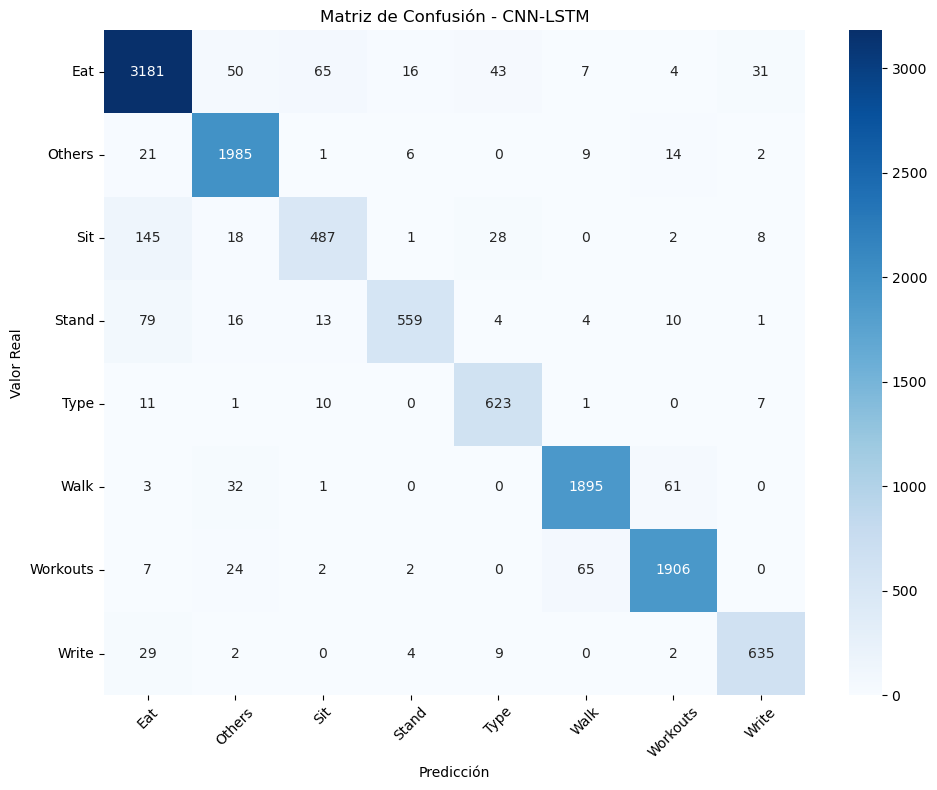

In [13]:
print("Evaluando modelo...")

# Predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Métricas básicas
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nPérdida en test: {test_loss:.4f}")
print(f"Precisión en test: {test_accuracy:.4f}")

# Reporte de clasificación detallado
print("\n" + "="*50)
print("REPORTE DE CLASIFICACIÓN")
print("="*50)
print(classification_report(
    y_test, 
    y_pred_classes, 
    target_names=label_encoder.classes_,
    digits=4
))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Matriz de Confusión - CNN-LSTM')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [19]:
model.save(r'../models/cnn_lstm_har_model_92.h5')

In [22]:
joblib.dump(label_encoder, r'../models/meta/label_encoder_92%.joblib')

['../models/meta/label_encoder_92%.joblib']

# 🧠 Agregar Nueva Actividad a Modelo Entrenado

## ¿Es posible? ¡SÍ! Pero con consideraciones importantes...

Cuando tienes un modelo entrenado (como tu `cnn-lstm_har_model_82.h5`) y quieres agregar una nueva actividad, tienes **3 enfoques principales**:

### 1. 🔄 **Reentrenamiento Completo** (Recomendado para mejor rendimiento)
- Agregar los datos de la nueva clase
- Reentrenar desde cero con todas las clases
- **Ventajas**: Mejor rendimiento, equilibrio entre clases
- **Desventajas**: Requiere más tiempo y recursos

### 2. 🏗️ **Transfer Learning / Fine-tuning**
- Congelar las capas iniciales
- Reentrenar solo las capas finales con datos nuevos
- **Ventajas**: Más rápido, aprovecha conocimiento previo
- **Desventajas**: Posible desequilibrio, rendimiento subóptimo

### 3. 🔧 **Arquitectura Expandible**
- Modificar la capa de salida para incluir la nueva clase
- Reentrenar con datos combinados
- **Ventajas**: Flexibilidad, mantenimiento del conocimiento
- **Desventajas**: Requiere diseño arquitectónico previo

In [14]:
# =============================================================================
# ANÁLISIS DEL MODELO EXISTENTE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np

# Cargar el modelo existente
model_path = "../models/cnn-lstm_har_model_82.h5"

try:
    model = load_model(model_path)
    print("✅ Modelo cargado exitosamente")
    
    # Información básica del modelo
    print(f"\n📊 INFORMACIÓN DEL MODELO:")
    print(f"Número de capas: {len(model.layers)}")
    print(f"Forma de entrada: {model.input_shape}")
    print(f"Forma de salida: {model.output_shape}")
    
    # Mostrar la arquitectura
    print(f"\n🏗️ ARQUITECTURA DEL MODELO:")
    model.summary()
    
    # Analizar la última capa (clasificación)
    last_layer = model.layers[-1]
    current_classes = last_layer.output_shape[-1]
    print(f"\n🎯 CLASES ACTUALES: {current_classes}")
    
except Exception as e:
    print(f"❌ Error cargando modelo: {e}")
    print("Esto es normal si el modelo aún no existe o está en otra ubicación")

✅ Modelo cargado exitosamente

📊 INFORMACIÓN DEL MODELO:
Número de capas: 19
Forma de entrada: (None, 1, 136)
Forma de salida: (None, 18)

🏗️ ARQUITECTURA DEL MODELO:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 64)          │         8,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 128)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1, 256)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 325,908 (1.24 MB)

 Trainable params: 324,242 (1.24 MB)

 Non-trainable params: 1,664 (6.50 KB)

 Optimizer params: 2 (12.00 B)

❌ Error cargando modelo: 'Dense' object has no attribute 'output_shape'
Esto es normal si el modelo aún no existe o está en otra ubicación


In [15]:
# =============================================================================
# ANÁLISIS DE ACTIVIDADES ACTUALES
# =============================================================================

import yaml
import os

# Cargar configuración de actividades
config_path = "../config/activities.yaml"

try:
    with open(config_path, 'r', encoding='utf-8') as file:
        activities_config = yaml.safe_load(file)
    
    print("✅ Configuración de actividades cargada")
    
    # Mostrar actividades actuales
    if 'config' in activities_config:
        current_activities = activities_config['config']
        print(f"\n🎯 ACTIVIDADES ACTUALES ({len(current_activities)}):")
        for code, activity in current_activities.items():
            print(f"  {code}: {activity}")
    
    # Actividades en español
    if 'activities' in activities_config:
        spanish_activities = activities_config['activities']
        print(f"\n🇪🇸 TRADUCCIONES AL ESPAÑOL:")
        for eng, esp in spanish_activities.items():
            print(f"  {eng} → {esp}")
            
except Exception as e:
    print(f"❌ Error cargando configuración: {e}")

# Simular agregar nueva actividad
print(f"\n💡 EJEMPLO: Agregar nueva actividad 'Cycling' (Ciclismo)")
new_activity_code = "T"  # Siguiente código disponible
new_activity_name = "Cycling"
new_activity_spanish = "Ciclismo"

print(f"Código: {new_activity_code}")
print(f"Inglés: {new_activity_name}")
print(f"Español: {new_activity_spanish}")

✅ Configuración de actividades cargada

🎯 ACTIVIDADES ACTUALES (3):
  labels: {'A': 'Walking', 'B': 'Jogging', 'C': 'Stairs', 'D': 'Sitting', 'E': 'Standing', 'F': 'Typing', 'G': 'Brushing Teeth', 'H': 'Eating Soup', 'I': 'Eating Chips', 'J': 'Eating Pasta', 'K': 'Drinking from Cup', 'L': 'Eating Sandwich', 'M': 'Kicking (Soccer Ball)', 'O': 'Playing Catch w/Tennis Ball', 'P': 'Dribbling (Basketball)', 'Q': 'Writing', 'R': 'Clapping', 'S': 'Folding Clothes'}
  clusters: {'Walk': ['Walking', 'Jogging', 'Stairs'], 'Sit': ['Sitting'], 'Type': ['Typing'], 'Write': ['Writing'], 'Stand': ['Standing'], 'Eat': ['Eating Soup', 'Eating Chips', 'Eating Pasta', 'Eating Sandwich', 'Drinking from Cup'], 'Workouts': ['Kicking (Soccer Ball)', 'Playing Catch w/Tennis Ball', 'Dribbling (Basketball)'], 'Others': ['Clapping', 'Folding Clothes', 'Brushing Teeth']}
  activities: {'Walking': 'Caminando', 'Jogging': 'Trotando', 'Stairs': 'Subiendo escaleras', 'Sitting': 'Sentado', 'Standing': 'De pie', 'Typin

## 🛠️ Métodos Específicos para Agregar Nueva Clase

### Método 1: **Reentrenamiento Completo** ⭐ (Recomendado)

#### Pasos:
1. **Recopilar datos** de la nueva actividad
2. **Actualizar** el archivo `activities.yaml`
3. **Combinar** datos antiguos + nuevos
4. **Reentrenar** el modelo desde cero
5. **Evaluar** rendimiento

#### Ventajas:
- ✅ Mejor rendimiento general
- ✅ Equilibrio entre todas las clases
- ✅ Modelo más robusto

#### Desventajas:
- ❌ Requiere más tiempo de entrenamiento
- ❌ Necesita todos los datos originales

---

### Método 2: **Fine-tuning / Transfer Learning**

#### Pasos:
1. **Congelar** capas convolucionales
2. **Modificar** capa de salida (18 → 19 clases)
3. **Entrenar** solo capas densas finales
4. **Ajustar** con learning rate bajo

#### Ventajas:
- ✅ Más rápido
- ✅ Aprovecha características aprendidas
- ✅ Menos datos necesarios

#### Desventajas:
- ❌ Posible sesgo hacia clases antiguas
- ❌ Rendimiento subóptimo

In [16]:
# =============================================================================
# MÉTODO 1: REENTRENAMIENTO COMPLETO
# =============================================================================

def expand_model_architecture(original_model, new_num_classes, learning_rate=0.001):
    """
    Expande un modelo existente para incluir más clases
    """
    try:
        # Obtener la arquitectura sin la última capa
        base_model = tf.keras.Model(
            inputs=original_model.input,
            outputs=original_model.layers[-2].output  # Penúltima capa
        )
        
        # Agregar nueva capa de clasificación
        x = base_model.output
        predictions = tf.keras.layers.Dense(
            new_num_classes, 
            activation='softmax', 
            name='new_classification'
        )(x)
        
        # Crear nuevo modelo
        new_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
        
        # Compilar
        new_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return new_model
        
    except Exception as e:
        print(f"❌ Error expandiendo modelo: {e}")
        return None

# Ejemplo de uso (simulado)
if 'model' in locals():
    print("🔧 EXPANDIENDO MODELO PARA NUEVA CLASE...")
    
    current_classes = model.output_shape[-1]
    new_classes = current_classes + 1  # Agregar 1 nueva clase
    
    print(f"Clases actuales: {current_classes}")
    print(f"Clases nuevas: {new_classes}")
    
    # Expandir modelo
    expanded_model = expand_model_architecture(model, new_classes)
    
    if expanded_model:
        print("✅ Modelo expandido exitosamente")
        print(f"Nueva forma de salida: {expanded_model.output_shape}")
        expanded_model.summary()
    else:
        print("❌ No se pudo expandir el modelo")
else:
    print("⚠️ Modelo no disponible. Carga el modelo primero.")

🔧 EXPANDIENDO MODELO PARA NUEVA CLASE...
Clases actuales: 18
Clases nuevas: 19
❌ Error expandiendo modelo: The layer sequential has never been called and thus has no defined input.
❌ No se pudo expandir el modelo


In [17]:
# =============================================================================
# MÉTODO 2: FINE-TUNING / TRANSFER LEARNING
# =============================================================================

def fine_tune_for_new_class(original_model, new_num_classes, freeze_layers=True):
    """
    Aplica fine-tuning para agregar nueva clase
    """
    try:
        # Crear nuevo modelo basado en el original
        new_model = expand_model_architecture(original_model, new_num_classes, learning_rate=0.0001)
        
        if freeze_layers:
            # Congelar todas las capas excepto las últimas 2
            for i, layer in enumerate(new_model.layers[:-2]):
                layer.trainable = False
                print(f"Capa {i} ({layer.name}) congelada")
            
            # Mantener entrenables las últimas capas
            for i, layer in enumerate(new_model.layers[-2:]):
                layer.trainable = True
                print(f"Capa {len(new_model.layers)-2+i} ({layer.name}) entrenable")
        
        return new_model
        
    except Exception as e:
        print(f"❌ Error en fine-tuning: {e}")
        return None

def update_activities_config(new_activity_code, new_activity_name, new_activity_spanish):
    """
    Actualiza el archivo de configuración con nueva actividad
    """
    try:
        config_path = "../config/activities.yaml"
        
        # Cargar configuración actual
        with open(config_path, 'r', encoding='utf-8') as file:
            config = yaml.safe_load(file)
        
        # Agregar nueva actividad
        config['config'][new_activity_code] = new_activity_name
        config['activities'][new_activity_name] = new_activity_spanish
        
        # Guardar configuración actualizada
        with open(config_path, 'w', encoding='utf-8') as file:
            yaml.dump(config, file, default_flow_style=False, allow_unicode=True)
        
        print(f"✅ Configuración actualizada con {new_activity_name}")
        return True
        
    except Exception as e:
        print(f"❌ Error actualizando configuración: {e}")
        return False

# Ejemplo de fine-tuning
if 'model' in locals():
    print("🔧 APLICANDO FINE-TUNING...")
    
    fine_tuned_model = fine_tune_for_new_class(model, model.output_shape[-1] + 1)
    
    if fine_tuned_model:
        print("✅ Fine-tuning aplicado exitosamente")
        print("\n📊 RESUMEN DEL MODELO FINE-TUNED:")
        
        # Contar capas entrenables vs congeladas
        trainable_params = fine_tuned_model.count_params()
        total_params = sum([layer.count_params() for layer in fine_tuned_model.layers])
        
        print(f"Parámetros totales: {total_params:,}")
        print(f"Parámetros entrenables: {trainable_params:,}")
        print(f"Parámetros congelados: {total_params - trainable_params:,}")
else:
    print("⚠️ Modelo no disponible para fine-tuning")

🔧 APLICANDO FINE-TUNING...
❌ Error expandiendo modelo: The layer sequential has never been called and thus has no defined input.
❌ Error en fine-tuning: 'NoneType' object has no attribute 'layers'


## ⚠️ Consideraciones Importantes

### 🎯 **Calidad de Datos para Nueva Clase**
- **Cantidad suficiente**: Mínimo 1000-2000 muestras por clase
- **Variabilidad**: Diferentes usuarios, dispositivos, condiciones
- **Balance**: Proporción similar a las clases existentes
- **Calidad**: Etiquetado correcto y limpio

### 🔄 **Proceso de Reentrenamiento**
1. **Backup del modelo actual** (muy importante!)
2. **Preparar datos combinados** (antiguos + nuevos)
3. **Balancear clases** (evitar sesgo)
4. **Validación cruzada** con datos de prueba
5. **Comparar rendimiento** antes vs después

### 📊 **Métricas a Monitorear**
- **Accuracy general** del modelo
- **Precision/Recall** por clase individual
- **Confusion Matrix** para detectar confusiones
- **F1-Score** balanceado
- **Tiempo de inferencia** (no debe aumentar significativamente)

### 🚨 **Problemas Comunes**
- **Catastrophic Forgetting**: El modelo "olvida" clases antiguas
- **Class Imbalance**: Nueva clase con pocos datos
- **Overfitting**: Modelo se sobreajusta a nueva clase
- **Degradación**: Performance general disminuye

---

## 💡 **Recomendación Final**

Para tu modelo HAR con 82% de accuracy:

1. **Si tienes buenos datos**: Usa **Reentrenamiento Completo**
2. **Si datos son limitados**: Usa **Fine-tuning** primero, luego completo
3. **Siempre evalúa**: Compara con modelo original
4. **Considera ensemble**: Combinar modelo original + nuevo si es necesario

In [18]:
# =============================================================================
# FLUJO COMPLETO: AGREGAR NUEVA ACTIVIDAD
# =============================================================================

def complete_workflow_add_activity(
    model_path,
    new_activity_code,
    new_activity_name,
    new_activity_spanish,
    new_data_X,
    new_data_y,
    existing_data_X=None,
    existing_data_y=None,
    method='retrain',  # 'retrain' o 'finetune'
    validation_split=0.2
):
    """
    Flujo completo para agregar nueva actividad al modelo HAR
    
    Parameters:
    -----------
    model_path : str
        Ruta al modelo existente
    new_activity_code : str
        Código de la nueva actividad (ej: 'T')
    new_activity_name : str
        Nombre en inglés de la actividad
    new_activity_spanish : str
        Nombre en español de la actividad
    new_data_X : array
        Datos de entrada para la nueva actividad
    new_data_y : array
        Etiquetas para la nueva actividad
    existing_data_X : array, optional
        Datos existentes (para reentrenamiento completo)
    existing_data_y : array, optional
        Etiquetas existentes (para reentrenamiento completo)
    method : str
        'retrain' para reentrenamiento completo, 'finetune' para fine-tuning
    validation_split : float
        Proporción de datos para validación
    
    Returns:
    --------
    dict : Resultados del entrenamiento
    """
    
    results = {
        'success': False,
        'model': None,
        'history': None,
        'metrics': None,
        'message': ''
    }
    
    try:
        print("🚀 INICIANDO FLUJO COMPLETO...")
        
        # 1. Cargar modelo existente
        print("📥 Cargando modelo existente...")
        original_model = load_model(model_path)
        current_classes = original_model.output_shape[-1]
        new_classes = current_classes + 1
        
        # 2. Actualizar configuración
        print("📝 Actualizando configuración...")
        config_updated = update_activities_config(
            new_activity_code, 
            new_activity_name, 
            new_activity_spanish
        )
        
        if not config_updated:
            results['message'] = 'Error actualizando configuración'
            return results
        
        # 3. Preparar datos
        print("🔄 Preparando datos...")
        if method == 'retrain' and existing_data_X is not None:
            # Combinar datos existentes + nuevos
            X_combined = np.concatenate([existing_data_X, new_data_X], axis=0)
            y_combined = np.concatenate([existing_data_y, new_data_y], axis=0)
        else:
            # Solo nuevos datos (fine-tuning)
            X_combined = new_data_X
            y_combined = new_data_y
        
        # 4. Crear nuevo modelo
        print("🏗️ Creando nuevo modelo...")
        if method == 'retrain':
            new_model = expand_model_architecture(original_model, new_classes)
        else:  # fine-tuning
            new_model = fine_tune_for_new_class(original_model, new_classes)
        
        if new_model is None:
            results['message'] = 'Error creando nuevo modelo'
            return results
        
        # 5. Preparar callbacks
        callbacks = [
            EarlyStopping(patience=10, restore_best_weights=True),
            ReduceLROnPlateau(patience=5, factor=0.5)
        ]
        
        # 6. Entrenar modelo
        print("🎯 Entrenando modelo...")
        history = new_model.fit(
            X_combined, y_combined,
            validation_split=validation_split,
            epochs=50,  # Ajustar según necesidad
            batch_size=64,
            callbacks=callbacks,
            verbose=1
        )
        
        # 7. Evaluar modelo
        print("📊 Evaluando modelo...")
        # Aquí agregarías tu código de evaluación específico
        
        results['success'] = True
        results['model'] = new_model
        results['history'] = history
        results['message'] = f'Modelo actualizado exitosamente con {new_activity_name}'
        
        print("✅ FLUJO COMPLETO EXITOSO!")
        
    except Exception as e:
        results['message'] = f'Error en flujo completo: {str(e)}'
        print(f"❌ ERROR: {results['message']}")
    
    return results

# Ejemplo de uso (comentado para evitar ejecución accidental)
"""
# Ejemplo de cómo usar la función completa:
new_X = np.random.random((1000, 150, 6))  # Datos simulados
new_y = np.full((1000, 19), 0)  # 19 clases (18 + 1 nueva)
new_y[:, -1] = 1  # Marcar como nueva clase

results = complete_workflow_add_activity(
    model_path="../models/cnn-lstm_har_model_82.h5",
    new_activity_code="T",
    new_activity_name="Cycling",
    new_activity_spanish="Ciclismo",
    new_data_X=new_X,
    new_data_y=new_y,
    method='finetune'
)

if results['success']:
    # Guardar nuevo modelo
    results['model'].save("../models/cnn-lstm_har_model_updated.h5")
    print("Modelo guardado exitosamente!")
"""

print("🔧 Funciones para agregar nueva actividad definidas")
print("📝 Edita los parámetros y descomenta el código para usar")

🔧 Funciones para agregar nueva actividad definidas
📝 Edita los parámetros y descomenta el código para usar
